In [ ]:
import pandas as pd
# import requests as rq
import numpy as np
# from datetime import datetime, timedelta
# from concurrent.futures import ThreadPoolExecutor
# import plotly.express as px
from pathlib import Path
# import plotly.graph_objects as go
from tqdm import tqdm
# import matplotlib.pyplot as plt # 3.8.3
# from statsmodels.tsa.seasonal import seasonal_decompose
#import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
pd.options.mode.copy_on_write = True
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from itertools import product
import torch.nn as nn
import torch
# import torch.optim as optim 
import optuna
import json
# from concurrent.futures import ProcessPoolExecutor, as_completed
from torch.utils.data import DataLoader, TensorDataset
from arch import arch_model

ModuleNotFoundError: No module named 'torch'

In [4]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


In [18]:
tickers = ['GAZP', 'LKOH', 'NVTK', 'PLZL', 'ROSN', 'SBER', 'SIBN', 'TATN']

# SaChaBaD model (such a bad model - такая плохая модель)

In [19]:
window_size = 159

def calc_hist_vol(r, window_size):
    return r.rolling(window=window_size).std()*window_size/(window_size-1)

# # Добавление результатов в DataFrame
# dd['hist_vol'] = np.nan
# dd.loc[window_size:, 'hist_vol'] = calc_hist_vol(dd['log_return'], window_size)

# FE

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, significance_level=0.05):
    """
    Проверка стационарности временного ряда с помощью ADF-теста.
    
    Parameters:
        series (pd.Series): Временной ряд.
        significance_level (float): Уровень значимости для проверки гипотезы.

    Returns:
        bool: True, если ряд стационарный, иначе False.
        dict: Результаты теста ADF.
    """
    result = adfuller(series.dropna())  # Удаляем NaN значения
    p_value = result[1]
    is_stationary = p_value < significance_level

    test_summary = {
        'Test Statistic': result[0],
        'p-value': p_value,
        'Critical Values': result[4],
        'Is Stationary': is_stationary
    }
    return is_stationary, test_summary

def load_and_check_stationarity(ticker: str, significance_level=0.05):
    dd = load_data_1h(ticker)
    dd['log_close'] = np.log(dd['close'])
    dd['log_return'] = dd['log_close'].diff()
    window_size = 159
    dd['vol'] = np.nan
    hist_vol = calc_hist_vol(dd['log_return'], window_size)
    if len(hist_vol) != len(dd.loc[window_size:, 'vol']):
        hist_vol = hist_vol[-len(dd.loc[window_size:, 'vol']):]  # Обрезаем до нужной длины

    # Использование .loc для безопасной записи
    dd.loc[window_size:, 'vol'] = hist_vol

    is_stationary, test_summary = check_stationarity(dd['vol'])
    if not is_stationary:
        print(f"Временной ряд {ticker} не стационарный. Результаты теста:")
        print(test_summary)
    else:
        print(f"Временной ряд {ticker} стационарный. Результаты теста:")
        print(test_summary)
    
    return dd

for ticker in tickers:
    load_and_check_stationarity(ticker)

Временной ряд GAZP стационарный. Результаты теста:
{'Test Statistic': -8.984674186683842, 'p-value': 7.154183666838273e-15, 'Critical Values': {'1%': -3.4305272915966016, '5%': -2.8616183586307486, '10%': -2.5668117078144466}, 'Is Stationary': True}
Временной ряд LKOH стационарный. Результаты теста:
{'Test Statistic': -7.860290806017542, 'p-value': 5.3065523421603424e-12, 'Critical Values': {'1%': -3.4305272819837667, '5%': -2.861618354382233, '10%': -2.5668117055530746}, 'Is Stationary': True}
Временной ряд NVTK стационарный. Результаты теста:
{'Test Statistic': -7.143352056263302, 'p-value': 3.280472219695026e-10, 'Critical Values': {'1%': -3.4305274888897124, '5%': -2.861618445826961, '10%': -2.5668117542266793}, 'Is Stationary': True}
Временной ряд PLZL стационарный. Результаты теста:
{'Test Statistic': -7.071824936046438, 'p-value': 4.914753150018763e-10, 'Critical Values': {'1%': -3.430527493707225, '5%': -2.8616184479561224, '10%': -2.5668117553599754}, 'Is Stationary': True}
Вр

In [63]:
def load_data_1h(ticker: str):
    return pd.read_csv(f'data_moex/{ticker}_volume.csv')

def normalize_data(dd):
    dd['log_close'] = np.log(dd['close'])
    dd['log_return'] = dd['log_close'].diff()

    window_size = 159
    dd['vol'] = np.nan
    dd.loc[window_size:, 'vol'] = calc_hist_vol(dd['log_return'], window_size)
    
    dd_norm = dd[159:].reset_index(drop=True)
    scaler = StandardScaler()
    dd_norm['log_return'] = scaler.fit_transform(dd_norm['log_return'].values.reshape(-1, 1))
    scaler = StandardScaler()
    dd_norm['vol'] = scaler.fit_transform(dd_norm['vol'].values.reshape(-1, 1))
    mean, std = scaler.mean_, scaler.scale_
    return dd_norm, mean, std, scaler

def arima_cross_validation(dd, n_splits: int, forecast_horizon: int):
    predictions = []

    total_length = len(dd)
    train_size = total_length - (n_splits + 1) * forecast_horizon

    for i in tqdm(range(n_splits)):
        train_start = train_size + i * forecast_horizon
        train_end = train_start + forecast_horizon

        train_data = dd['vol'].iloc[:train_end]
        # print(train_data)

        model = pm.auto_arima(
    		train_data, 
            # exogenous = dd_train_norm[['close']],
			test='adf',
            start_p=1, start_q=1, 
            max_p=3, max_q=3, 
			seasonal=False,  # Если ваш ряд не имеет сезонности
			trace=False,      # Отображает результаты подбора
            d = 0,
			error_action='ignore',  # Игнорировать ошибки
			suppress_warnings=True, # Подавить предупреждения
            stepwise=True)
        forecast = model.predict(n_periods=forecast_horizon)
        
        predictions.extend(forecast)
        
        # rmse = np.sqrt(mean_squared_error(test_data.values, forecast_volatility))
        # errors.append(rmse)

    return np.array(predictions)

def vol_arima_cv(tickers: list, n_splits: int = 20, forecast_horizon: int = 159):
    results = {}

    for ticker in tqdm(tickers):
        dd = load_data_1h(ticker)
        dd, mean, std, scaler = normalize_data(dd)

        # print(dd)
        # Кросс-валидация
        predictions = arima_cross_validation(dd, n_splits, forecast_horizon)
        # print(f'{ticker} - CV RMSE: {cv_rmse:.4f}')

        # Декодирование нормализованных данных
        predictions = predictions * std + mean

        dd['vol'] = scaler.inverse_transform(dd['vol'].values.reshape(-1, 1))
        
        # Сохранение результатов
        new_rows = pd.DataFrame({
            'forecast_vol': predictions,
            'actual_vol': dd.iloc[-n_splits * forecast_horizon:]['vol'].to_numpy()
        })
        results[ticker] = new_rows

    return results

In [ ]:
results_fe = vol_arima_cv(tickers)
results_fe

# GARCH

In [33]:
def load_data_1h(ticker: str):
    return pd.read_csv(f'data_moex/{ticker}_volume.csv')

def normalize_data(dd):
    dd['log_close'] = np.log(dd['close'])
    dd['log_return'] = dd['log_close'].diff()

    window_size = 159
    dd['vol'] = np.nan
    dd.loc[window_size:, 'vol'] = calc_hist_vol(dd['log_return'], window_size)
    
    dd_norm = dd[158:].reset_index(drop=True)
    scaler = StandardScaler()
    dd_norm['log_return'] = scaler.fit_transform(dd_norm['log_return'].values.reshape(-1, 1))
    scaler = StandardScaler()
    dd_norm['vol'] = scaler.fit_transform(dd_norm['vol'].values.reshape(-1, 1))
    mean, std = scaler.mean_, scaler.scale_
    return dd_norm, mean, std, scaler

def garch_cross_validation(dd, n_splits: int, forecast_horizon: int, p: int, q: int):
    predictions = []

    total_length = len(dd)
    train_size = total_length - (n_splits + 1) * forecast_horizon

    for i in range(n_splits):
        train_start = train_size + i * forecast_horizon
        train_end = train_start + forecast_horizon

        train_data = dd['log_return'].iloc[:train_end]

        model = arch_model(train_data, mean='Constant', vol="GARCH", p=p, q=q, dist="Normal")
        garch_fit = model.fit(disp="off")
        forecast = garch_fit.forecast(horizon=forecast_horizon,  method='simulation', simulations=1000)
        
        forecast_volatility = np.sqrt(forecast.variance.values[-1])  # Прогнозируемые волатильности
        predictions.extend(forecast_volatility)
        
        # rmse = np.sqrt(mean_squared_error(test_data.values, forecast_volatility))
        # errors.append(rmse)

    return np.array(predictions)

def vol_garch_cv(tickers: list, n_splits: int = 20, forecast_horizon: int = 159, p: int = 1, q: int = 1):
    results = {}

    for ticker in tqdm(tickers):
        dd = load_data_1h(ticker)
        dd, mean, std, scaler = normalize_data(dd)

        # Кросс-валидация
        predictions = garch_cross_validation(dd, n_splits, forecast_horizon, p, q)
        # print(f'{ticker} - CV RMSE: {cv_rmse:.4f}')

        # Декодирование нормализованных данных
        predictions = predictions * std + mean

        dd['vol'] = scaler.inverse_transform(dd['vol'].values.reshape(-1, 1))
        
        # Сохранение результатов
        new_rows = pd.DataFrame({
            'forecast_vol': predictions,
            'actual_vol': dd.iloc[-n_splits * forecast_horizon:]['vol'].to_numpy()
        })
        results[ticker] = new_rows

    return results

In [ ]:
# from itertools import product
# from sklearn.metrics import mean_squared_error

# def optimize_garch_params(tickers: list, n_splits: int = 20, forecast_horizon: int = 159, 
#                           max_p: int = 5, max_q: int = 5):
#     best_params = {}
    
#     for ticker in tqdm(tickers):
#         dd = load_data_1h(ticker)
#         dd, mean, std, scaler = normalize_data(dd)
        
#         # Поиск лучших параметров
#         best_mse = float('inf')
#         best_pq = None
        
#         for p, q in product(range(1, max_p + 1), range(1, max_q + 1)):
#             try:
#                 # Кросс-валидация
#                 predictions = garch_cross_validation(dd, n_splits, forecast_horizon, p, q)
                
#                 # Декодирование нормализованных данных
#                 predictions = predictions * std + mean
#                 actual_vol = dd.iloc[-n_splits * forecast_horizon:]['vol'].to_numpy()
                
#                 # Инвертируем нормализацию
#                 actual_vol = scaler.inverse_transform(actual_vol.reshape(-1, 1)).flatten()
                
#                 # Вычисляем MSE
#                 mse = mean_squared_error(actual_vol, predictions)
                
#                 if mse < best_mse:
#                     best_mse = mse
#                     best_pq = (p, q)
#             except Exception as e:
#                 print(f"Ошибка для {ticker}, p={p}, q={q}: {e}")
#                 continue
        
#         best_params[ticker] = {'best_p': best_pq[0], 'best_q': best_pq[1], 'best_mse': best_mse}
    
#     return best_params

In [ ]:
# optimize_garch_params(tickers)

  0%|          | 0/8 [28:10<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
results_garch = vol_garch_cv(tickers)
results_garch

  0%|          | 0/8 [00:00<?, ?it/s]d:\Python\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
d:\Python\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
d:\Python\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
d:\Python\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 12%|█▎        

{'GAZP':       forecast_vol  actual_vol
 0         0.003930    0.001684
 1         0.003969    0.001690
 2         0.003993    0.001691
 3         0.004019    0.001692
 4         0.004059    0.001616
 ...            ...         ...
 3175      0.006391    0.002887
 3176      0.006358    0.002896
 3177      0.006445    0.002893
 3178      0.006429    0.002896
 3179      0.006442    0.002884
 
 [3180 rows x 2 columns],
 'LKOH':       forecast_vol  actual_vol
 0         0.003192    0.002172
 1         0.003197    0.002170
 2         0.003202    0.002168
 3         0.003207    0.002166
 4         0.003210    0.002113
 ...            ...         ...
 3175      0.004022    0.001789
 3176      0.004024    0.001808
 3177      0.004026    0.001809
 3178      0.004029    0.001814
 3179      0.004030    0.001783
 
 [3180 rows x 2 columns],
 'NVTK':       forecast_vol  actual_vol
 0         0.003363    0.002462
 1         0.003365    0.002467
 2         0.003366    0.002460
 3         0.003367    0

# ML

In [6]:
def load_data_1h(ticker: str):
    return pd.read_csv(f'data_moex/{ticker}_volume.csv')

def create_dataset(dd, n_splits, forecast_horizon, window_size):
    X, y = [], []
    start = len(dd) - (n_splits + window_size) * forecast_horizon
    end = len(dd) - n_splits * forecast_horizon - forecast_horizon

    for i in range(n_splits):   
        start += forecast_horizon
        end += forecast_horizon
        X.append(dd.iloc[start:end]['log_return'].values)
        y.append(dd.iloc[end:end + forecast_horizon]['log_return'].values)

    return np.array(X), np.array(y)

def normalize_data_minmax(dd):
    dd['log_close'] = np.log(dd['close'])
    dd['log_return'] = dd['log_close'].diff()
    
    window_size = 159
    dd['vol'] = np.nan
    dd.loc[window_size:, 'vol'] = calc_hist_vol(dd['log_return'], window_size)

    scaler = MinMaxScaler()
    dd_norm = dd[158:].reset_index(drop=True)
    dd_norm['vol'] = scaler.fit_transform(dd_norm['vol'].values.reshape(-1, 1))
    data_min, data_max = scaler.data_min_, scaler.data_max_
    return dd_norm, data_min, data_max, scaler

# Определение модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=159, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Используем последнее скрытое состояние
        return out

def vol_lstm(tickers: list, best_params_results: list, window_size: int = 500, n_splits: int = 20, forecast_horizon: int = 159):
    results = {}

    for ticker in tickers:
        # df = pd.DataFrame(columns=['forecast_volume', 'actual_volume'])

        torch.manual_seed(342)

        dd = load_data_1h(ticker)
        dd, min, max, scaler = normalize_data_minmax(dd)

        if ticker in best_params_results:
            # Получаем словарь параметров из кортежа (параметры, ошибка)
            best_params = best_params_results[ticker][0]
            best_hidden_size = best_params["hidden_size"]
            best_num_layers = best_params["num_layers"]
            best_learning_rate = best_params["learning_rate"]
            best_window_size = best_params['window_size']
            print(f"Параметры для тикера {ticker}: hidden_size={best_hidden_size}, num_layers={best_num_layers}, learning_rate={best_learning_rate}, window_size={best_window_size}")
        else:
            print(f"Параметры для тикера {ticker} не найдены, используем значения по умолчанию.")
            best_hidden_size = 100
            best_num_layers = 3
            best_learning_rate = 0.0005599305480432884
            best_window_size = 33

        X, y = create_dataset(dd.iloc[:-n_splits*forecast_horizon ], n_splits, forecast_horizon, best_window_size)
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Измените размерность на (batch_size, sequence_length, 1)
        y = torch.tensor(y, dtype=torch.float32)

        # Создание DataLoader для обучающих данных
        train_loader = DataLoader(TensorDataset(X, y), batch_size=n_splits, shuffle=True)

        model = LSTMModel(input_size=1, hidden_size=best_hidden_size, num_layers=best_num_layers).to('cpu')
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)

        num_epochs = 10
        for epoch in range(num_epochs):
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

        model.eval()
        last_sequence = torch.tensor(dd.iloc[- (n_splits + best_window_size) * forecast_horizon:-n_splits * forecast_horizon]['vol'].values, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        prediction = []
        actual_values = dd.iloc[-n_splits * forecast_horizon:]['vol'].values  # Реальные значения для подстановки
        with torch.no_grad():
            for i in range(n_splits):
                pred = model(last_sequence)
                prediction.append(pred[0].cpu().numpy())
                real_value = torch.tensor([actual_values[i]], dtype=torch.float32).unsqueeze(-1)
                last_sequence = torch.cat((last_sequence[:, 1:, :], real_value.unsqueeze(0)), dim=1)

        prediction = prediction * (max - min) + min
        dd['vol'] = scaler.inverse_transform(dd['vol'].values.reshape(-1, 1))
        score = np.sqrt(np.mean((np.array(prediction).flatten() - dd.iloc[-n_splits * forecast_horizon:]['vol'].values) ** 2))

        print(f'Score: {score:.4f} RMSE')

        new_rows = pd.DataFrame({
            'forecast_vol': prediction.ravel(),
            'actual_vol': dd.iloc[-n_splits * forecast_horizon:]['vol'].to_numpy()
        })
        
        results[ticker] = new_rows

    return results

# Подбор гипер параметров

In [ ]:
# # Функции загрузки и предобработки данных остаются такими же, как в вашем коде

# # Определение модели LSTM
# class LSTMModel(nn.Module):
#     def __init__(self, input_size=1, hidden_size=50, output_size=159, num_layers=1):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         batch_size = x.size(0)
#         h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# # Оптимизация гиперпараметров с использованием Optuna
# def objective(trial, ticker, n_splits=20, forecast_horizon=159, num_epochs=20):
#     # Загружаем и нормализуем данные
#     dd = load_data_1h(ticker)
#     dd, data_min, data_max, scaler = normalize_data_minmax(dd)

#     # Генерация гиперпараметров
#     window_size = trial.suggest_int("window_size", 3, 100)  # Оптимизация window_size
#     hidden_size = trial.suggest_int("hidden_size", 32, 128)
#     num_layers = trial.suggest_int("num_layers", 1, 3)
#     learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

#     # Создаем датасет для модели
#     X, y = create_dataset(dd.iloc[:-n_splits*forecast_horizon], n_splits, forecast_horizon, window_size)
#     X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
#     y = torch.tensor(y, dtype=torch.float32)
#     train_loader = DataLoader(TensorDataset(X, y), batch_size=n_splits, shuffle=True)

#     # Инициализация модели, критерия и оптимизатора
#     model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers).to('cpu')
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     # Обучение модели
#     for epoch in range(num_epochs):
#         model.train()
#         for inputs, targets in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
                
#     # Оценка на последней последовательности
#     model.eval()
#     last_sequence = torch.tensor(dd.iloc[- (n_splits + window_size) * forecast_horizon:-n_splits * forecast_horizon]['vol'].values, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
#     prediction = []
#     actual_values = dd.iloc[-n_splits * forecast_horizon:]['vol'].values  # Реальные значения для подстановки
#     with torch.no_grad():
#         for i in range(n_splits):
#             pred = model(last_sequence)
#             prediction.append(pred[0].cpu().numpy())
#             real_value = torch.tensor([actual_values[i]], dtype=torch.float32).unsqueeze(-1)
#             last_sequence = torch.cat((last_sequence[:, 1:, :], real_value.unsqueeze(0)), dim=1)

#     # Обратное преобразование предсказаний
#     prediction = prediction * (data_max - data_min) + data_min
#     dd['vol'] = scaler.inverse_transform(dd['vol'].values.reshape(-1, 1))

#     # Расчет RMSE
#     score = np.sqrt(np.mean((np.array(prediction).flatten() - dd.iloc[-n_splits * forecast_horizon:]['vol'].values) ** 2))
#     return score

# # Основная функция для запуска Optuna
# def tune_for_ticker(ticker, n_trials=5):
#     study = optuna.create_study(direction="minimize")
#     study.optimize(lambda trial: objective(trial, ticker), n_trials=n_trials)
#     print(f"\nЛучшие гиперпараметры для {ticker}: {study.best_params}")
#     print(f"Лучший RMSE: {study.best_value:.4f}")
#     return study.best_params, study.best_value

# # # Тестирование подбора гиперпараметров для каждого тикера
# if Path('best_params_results.json').exists():
#     with open("best_params_results.json", "r") as f:
#         best_params_results = json.load(f)
# else:
#     best_params_results = {}

# for ticker in tickers:
#     if ticker in best_params_results:
#         print(f"Тикер {ticker} уже заполнен.")
#     else:
#         print(f"\nЗапуск подбора гиперпараметров для {ticker}")
#         best_params, best_value = tune_for_ticker(ticker)
#         best_params_results[ticker] = (best_params, best_value)
#         with open("best_params_results.json", "w") as f:
#             json.dump(best_params_results, f)


# print("\nИтоговые результаты:")
# print(best_params_results)
# # def parallel_tuning(tickers, n_trials=20):
# #     logging.info("Начинаем подбор гиперпараметров для тикеров: %s", tickers)
# #     if Path('best_params_results.json').exists():
# #         with open("best_params_results.json", "r") as f:
# #             best_params_results = json.load(f)
# #     else:
# #         best_params_results = {}

# #     with ProcessPoolExecutor(max_workers=2) as executor:  # Ограничение числа параллельных процессов
# #         futures = {
# #             executor.submit(tune_for_ticker, ticker, n_trials): ticker
# #             for ticker in tickers if ticker not in best_params_results
# #         }

# #         for future in as_completed(futures):
# #             ticker = futures[future]
# #             try:
# #                 best_params, best_value = future.result()
# #                 logging.info(f"\nЛучшие гиперпараметры для {ticker}: {best_params}")
# #                 logging.info(f"Лучший RMSE: {best_value:.4f}")
# #                 best_params_results[ticker] = (best_params, best_value)

# #                 # Сохраняем результаты после каждого выполнения
# #                 with open("best_params_results.json", "w") as f:
# #                     json.dump(best_params_results, f)

# #             except Exception as e:
# #                 logging.error(f"Ошибка при подборе гиперпараметров для {ticker}: {e}")

# #     logging.info("\nИтоговые результаты:")
# #     logging.info(best_params_results)
# #     return best_params_results

# # # Тестирование параллельного подбора гиперпараметров
# # parallel_tuning(['GAZP'])

[I 2024-12-02 10:57:47,243] A new study created in memory with name: no-name-0b5480fe-cb03-44de-b211-79d92e4ba306


Тикер GAZP уже заполнен.
Тикер LKOH уже заполнен.
Тикер NVTK уже заполнен.

Запуск подбора гиперпараметров для PLZL


 24%|██▎       | 8733/36899 [00:09<00:30, 923.44it/s] 
[W 2024-12-02 10:57:57,098] Trial 0 failed with parameters: {} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "d:\Python\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\maxdu_rzsw30d\AppData\Local\Temp\ipykernel_24680\2392376374.py", line 76, in <lambda>
    study.optimize(lambda trial: objective(trial, ticker), n_trials=n_trials)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxdu_rzsw30d\AppData\Local\Temp\ipykernel_24680\2392376374.py", line 24, in objective
    dd, data_min, data_max, scaler = normalize_data_minmax(dd)
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxdu_rzsw30d\AppData\Local\Temp\ipykernel_24680\317739618.py", line 25, in normalize_data_minmax
    vol = calc_pre_avg_vol(window_data)
          ^^^^

KeyboardInterrupt: 

In [7]:
if Path('best_params_results.json').exists():
    with open("best_params_results.json", "r") as f:
        best_params_results = json.load(f)
else:
    best_params_results = {}

In [8]:
# results_ml = volume(tickers, best_params_results)
results_ml = vol_lstm(tickers, best_params_results)
results_ml

Параметры для тикера GAZP: hidden_size=72, num_layers=1, learning_rate=0.0038355366452982207, window_size=13
Epoch [10/10], Loss: 0.0001
Score: 0.0024 RMSE
Параметры для тикера LKOH: hidden_size=95, num_layers=1, learning_rate=0.008310736346480645, window_size=66
Epoch [10/10], Loss: 0.0001
Score: 0.0014 RMSE
Параметры для тикера NVTK: hidden_size=93, num_layers=3, learning_rate=0.006838125574482546, window_size=22
Epoch [10/10], Loss: 0.0001
Score: 0.0018 RMSE
Параметры для тикера PLZL не найдены, используем значения по умолчанию.
Epoch [10/10], Loss: 0.0010
Score: 0.0017 RMSE
Параметры для тикера ROSN не найдены, используем значения по умолчанию.
Epoch [10/10], Loss: 0.0010
Score: 0.0019 RMSE
Параметры для тикера SBER не найдены, используем значения по умолчанию.
Epoch [10/10], Loss: 0.0010
Score: 0.0016 RMSE
Параметры для тикера SIBN не найдены, используем значения по умолчанию.
Epoch [10/10], Loss: 0.0010
Score: 0.0022 RMSE
Параметры для тикера TATN не найдены, используем значения 

{'GAZP':       forecast_vol  actual_vol
 0         0.000498    0.001684
 1         0.000335    0.001690
 2         0.000437    0.001691
 3         0.000108    0.001692
 4         0.000161    0.001616
 ...            ...         ...
 3175      0.000778    0.002887
 3176      0.000161    0.002896
 3177      0.000425    0.002893
 3178      0.000968    0.002896
 3179      0.000618    0.002884
 
 [3180 rows x 2 columns],
 'LKOH':       forecast_vol  actual_vol
 0         0.000419    0.002172
 1         0.000403    0.002170
 2         0.000432    0.002168
 3         0.000445    0.002166
 4         0.000371    0.002113
 ...            ...         ...
 3175      0.000567    0.001789
 3176      0.000377    0.001808
 3177      0.000408    0.001809
 3178      0.000342    0.001814
 3179      0.000611    0.001783
 
 [3180 rows x 2 columns],
 'NVTK':       forecast_vol  actual_vol
 0         0.000718    0.002462
 1         0.000704    0.002467
 2         0.000823    0.002460
 3         0.000782    0

# Stacking

In [9]:
import numpy as np
import pandas as pd
import datetime
import ta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import torch
import torch.nn as nn
import xgboost as xgb
import torch.optim as optim 
import optuna 
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go


def load_data(ticker: str): 
    dd = pd.read_csv(f'data_moex/{ticker}_volume.csv')
    dd['log_close'] = np.log(dd['close'])
    dd['log_return'] = dd['log_close'].diff()
    window_size = 159
    dd['vol'] = np.nan
    dd.loc[window_size:, 'vol'] = calc_hist_vol(dd['log_return'], window_size)
    dd = dd.loc[:,['close', 'vol']]
    return dd

def data_preprocessing(ticker : str):
    data = load_data(ticker)
    # 1. Simple Moving Average (SMA)
    data['sma_10'] = data['close'].rolling(window=10).mean()
    data['sma_20'] = data['close'].rolling(window=20).mean()

    # 2. Exponential Moving Average (EMA)
    data['ema_10'] = data['close'].ewm(span=10, adjust=False).mean()
    data['ema_20'] = data['close'].ewm(span=20, adjust=False).mean()

    # 3. Relative Strength Index (RSI)
    data['rsi'] = ta.momentum.RSIIndicator(close=data['close'], window=14).rsi()

    # 4. Moving Average Convergence Divergence (MACD)
    macd = ta.trend.MACD(close=data['close'])
    data['macd'] = macd.macd()
    data['macd_signal'] = macd.macd_signal()

    # 5. Bollinger Bands
    bollinger = ta.volatility.BollingerBands(close=data['close'], window=20, window_dev=2)
    data['bollinger_mavg'] = bollinger.bollinger_mavg()
    data['bollinger_hband'] = bollinger.bollinger_hband()
    data['bollinger_lband'] = bollinger.bollinger_lband()

    # 6. Rate of Change (ROC)
    data['roc'] = ta.momentum.ROCIndicator(close=data['close'], window=12).roc()

    # 7. Stochastic Oscillator
    data['stoch_k'] = ((data['close'] - data['close'].rolling(window=14).min()) /
                    (data['close'].rolling(window=14).max() - data['close'].rolling(window=14).min())) * 100

    # 8. Momentum
    data['momentum'] = data['close'] - data['close'].shift(4)

    # 9. Detrended Price Oscillator (DPO)
    data['dpo'] = data['close'] - data['close'].rolling(window=14).mean()

    data[['sma_10', 'ema_10', 'rsi', 'macd', 'bollinger_mavg', 'roc', 'stoch_k', 'momentum', 'dpo']].head()
    data = data.dropna(axis=0)
    return data


def future_selection(X, y):
    model = xgb.XGBRegressor()
    model.fit(X,y)
    xgb.plot_importance(model)
    plt.show()


def stacking(ticker : str):
    data = data_preprocessing(ticker)
    y = data['vol']
    X = data.drop(columns=['vol', 'ema_10', 'ema_20', 'sma_20', 'sma_10', 'bollinger_hband', 'bollinger_lband', 'stoch_k', 'roc'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3180/len(y),shuffle=False, random_state=42)

    rf_model = RandomForestRegressor(max_depth= 7,
        max_features= 0.6705241236872915,
        max_leaf_nodes= 48,
        min_samples_leaf= 2,
        min_samples_split= 5,
        n_estimators= 138,
        random_state=42)

    gb_model = xgb.XGBRegressor(colsample_bytree= 0.7865412521282844, 
        gamma=0.5908332605690108, 
        learning_rate= 0.04050024993904943, 
        max_depth= 4, 
        n_estimators= 219, 
        reg_alpha= 0.8226005606596583, 
        reg_lambda= 0.3601906414112629, 
        subsample= 0.6270605126518848,
        random_state=42)
    lr_model = LinearRegression()

    rf_model.fit(X_train, y_train)
    gb_model.fit(X_train, y_train)
    lr_model.fit(X_train, y_train)

    rf_pred = rf_model.predict(X_test)
    gb_pred = gb_model.predict(X_test)
    lr_pred = lr_model.predict(X_test)
    dd = load_data(ticker)
    stack = pd.DataFrame({'rf': rf_pred, 'gb': gb_pred, 'lr': lr_pred, 'actual_vol': dd.iloc[-3180:]['vol'].to_numpy()})

    return stack

In [10]:
all_stacks = []

for ticker in tickers:
    stack = stacking(ticker)
    all_stacks.append(stack)

# Объединение всех данных в один DataFrame
combined_data = pd.concat(all_stacks, ignore_index=True)

# Вывод или сохранение результирующего датафрейма
print(combined_data)

             rf        gb        lr  actual_vol
0      0.002742  0.002157  0.001450    0.001684
1      0.002733  0.002157  0.001433    0.001690
2      0.002742  0.002157  0.001451    0.001691
3      0.002742  0.002157  0.001480    0.001692
4      0.002742  0.002157  0.001489    0.001616
...         ...       ...       ...         ...
25435  0.002948  0.002094  0.002444    0.002814
25436  0.002901  0.002094  0.002337    0.002869
25437  0.002742  0.002094  0.002385    0.002871
25438  0.002697  0.002094  0.002323    0.002883
25439  0.002655  0.002094  0.002362    0.002871

[25440 rows x 4 columns]


In [11]:
ticker_column = []
rows_per_ticker = 3180  # количество строк на тикер

# Создаем список тикеров с повторяющимися значениями для каждого тикера
ticker_column = [ticker for ticker in tickers for _ in range(rows_per_ticker)]

# Проверяем, что размер списка совпадает с количеством строк в DataFrame
if len(ticker_column) == len(combined_data):
    combined_data['ticker'] = ticker_column
else:
    print("Размеры не совпадают, проверьте количество строк и тикеров.")

# Проверка результата
combined_data

,rf,gb,lr,actual_vol,ticker
0,0.002742,0.002157,0.001450,0.001684,GAZP
1,0.002733,0.002157,0.001433,0.001690,GAZP
2,0.002742,0.002157,0.001451,0.001691,GAZP
3,0.002742,0.002157,0.001480,0.001692,GAZP
4,0.002742,0.002157,0.001489,0.001616,GAZP
...,...,...,...,...,...
25435,0.002948,0.002094,0.002444,0.002814,TATN
25436,0.002901,0.002094,0.002337,0.002869,TATN
25437,0.002742,0.002094,0.002385,0.002871,TATN
25438,0.002697,0.002094,0.002323,0.002883,TATN


In [12]:
for ticker, lstm_df in results_ml.items():
    # Выделим только нужные столбцы из текущего DataFrame для тикера и добавим в столбец 'lstm'
    lstm_values = lstm_df['forecast_vol'].values
    # Сравним количество значений в combined_data для данного тикера и количество значений в lstm_df
    if len(lstm_values) == combined_data[combined_data['ticker'] == ticker].shape[0]:
        # Заполняем столбец 'lstm' данными из lstm_values для текущего тикера
        combined_data.loc[combined_data['ticker'] == ticker, 'lstm'] = lstm_values
    else:
        print(f"Размер данных для тикера {ticker} не совпадает.")

# Проверка результата
combined_data

,rf,gb,lr,actual_vol,ticker,lstm
0,0.002742,0.002157,0.001450,0.001684,GAZP,0.000498
1,0.002733,0.002157,0.001433,0.001690,GAZP,0.000335
2,0.002742,0.002157,0.001451,0.001691,GAZP,0.000437
3,0.002742,0.002157,0.001480,0.001692,GAZP,0.000108
4,0.002742,0.002157,0.001489,0.001616,GAZP,0.000161
...,...,...,...,...,...,...
25435,0.002948,0.002094,0.002444,0.002814,TATN,0.000567
25436,0.002901,0.002094,0.002337,0.002869,TATN,0.000708
25437,0.002742,0.002094,0.002385,0.002871,TATN,0.000345
25438,0.002697,0.002094,0.002323,0.002883,TATN,0.000605


In [13]:
for ticker, fe_df in results_fe.items():
    # Выделим только нужные столбцы из текущего DataFrame для тикера и добавим в столбец 'fe'
    lstm_values = fe_df['forecast_vol'].values
    # Сравним количество значений в combined_data для данного тикера и количество значений в fe_df
    if len(lstm_values) == combined_data[combined_data['ticker'] == ticker].shape[0]:
        # Заполняем столбец 'lstm' данными из lstm_values для текущего тикера
        combined_data.loc[combined_data['ticker'] == ticker, 'fe'] = lstm_values
    else:
        print(f"Размер данных для тикера {ticker} не совпадает.")

# Проверка результата
combined_data

,rf,gb,lr,actual_vol,ticker,lstm,fe
0,0.002742,0.002157,0.001450,0.001684,GAZP,0.000498,0.003930
1,0.002733,0.002157,0.001433,0.001690,GAZP,0.000335,0.003963
2,0.002742,0.002157,0.001451,0.001691,GAZP,0.000437,0.003996
3,0.002742,0.002157,0.001480,0.001692,GAZP,0.000108,0.004028
4,0.002742,0.002157,0.001489,0.001616,GAZP,0.000161,0.004060
...,...,...,...,...,...,...,...
25435,0.002948,0.002094,0.002444,0.002814,TATN,0.000567,0.003406
25436,0.002901,0.002094,0.002337,0.002869,TATN,0.000708,0.003406
25437,0.002742,0.002094,0.002385,0.002871,TATN,0.000345,0.003406
25438,0.002697,0.002094,0.002323,0.002883,TATN,0.000605,0.003406


In [ ]:
for ticker, garch_df in results_garch.items():
    # Выделим только нужные столбцы из текущего DataFrame для тикера и добавим в столбец 'fe'
    lstm_values = garch_df['forecast_vol'].values
    # Сравним количество значений в combined_data для данного тикера и количество значений в fe_df
    if len(lstm_values) == combined_data[combined_data['ticker'] == ticker].shape[0]:
        # Заполняем столбец 'lstm' данными из lstm_values для текущего тикера
        combined_data.loc[combined_data['ticker'] == ticker, 'garch'] = lstm_values
    else:
        print(f"Размер данных для тикера {ticker} не совпадает.")

# Проверка результата
combined_data

In [ ]:
ticker_dfs = {ticker: df for ticker, df in combined_data.groupby('ticker')}

# Инициализируем списки для хранения результатов
results = []

# Проходим по каждому датафрейму для тикера
for ticker, df in ticker_dfs.items():
    # Подготовка данных
    X = df[['rf', 'gb', 'lr', 'lstm', 'fe', 'garch']].values  # Признаки
    y = df['actual_vol'].values  # Целевая переменная

    # Обучаем метамодель
    meta_model = LinearRegression()
    meta_model.fit(X, y)

    # Прогнозируем
    meta_pred = meta_model.predict(X)

    # Рассчитываем метрики
    mse = mean_squared_error(y, meta_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, meta_pred)
    mape = np.mean(np.abs((y - meta_pred) / y)) * 100  # В процентах

    # Сохраняем результаты
    results.append({
        'ticker': ticker,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    })

# Создаем итоговый датафрейм с метриками
metrics_df = pd.DataFrame(results)

# Проверка результатов
print(metrics_df)

  ticker           mse      rmse       mae       mape
0   GAZP  6.661362e-07  0.000816  0.000646  25.816242
1   LKOH  1.017725e-07  0.000319  0.000270  16.242633
2   NVTK  1.950367e-07  0.000442  0.000329  14.716887
3   PLZL  2.066391e-07  0.000455  0.000359  17.475862
4   ROSN  2.421107e-07  0.000492  0.000410  19.931562
5   SBER  9.585334e-08  0.000310  0.000241  13.743677
6   SIBN  9.710424e-07  0.000985  0.000656  31.173384
7   TATN  5.758166e-07  0.000759  0.000609  27.199837


In [15]:
def calc_mase(y_true, y_pred, y_train):
    # Calculate the naive forecast (previous value)
    naive_forecast = np.roll(y_train, 1)
    naive_forecast[0] = y_train[0]

    # Calculate the absolute error of the naive forecast
    naive_error = np.mean(np.abs(y_train - naive_forecast))

    # Calculate the absolute error of the predicted values
    predicted_error = np.mean(np.abs(y_true - y_pred))

    # Calculate the MASE
    mase = predicted_error / naive_error

    return mase

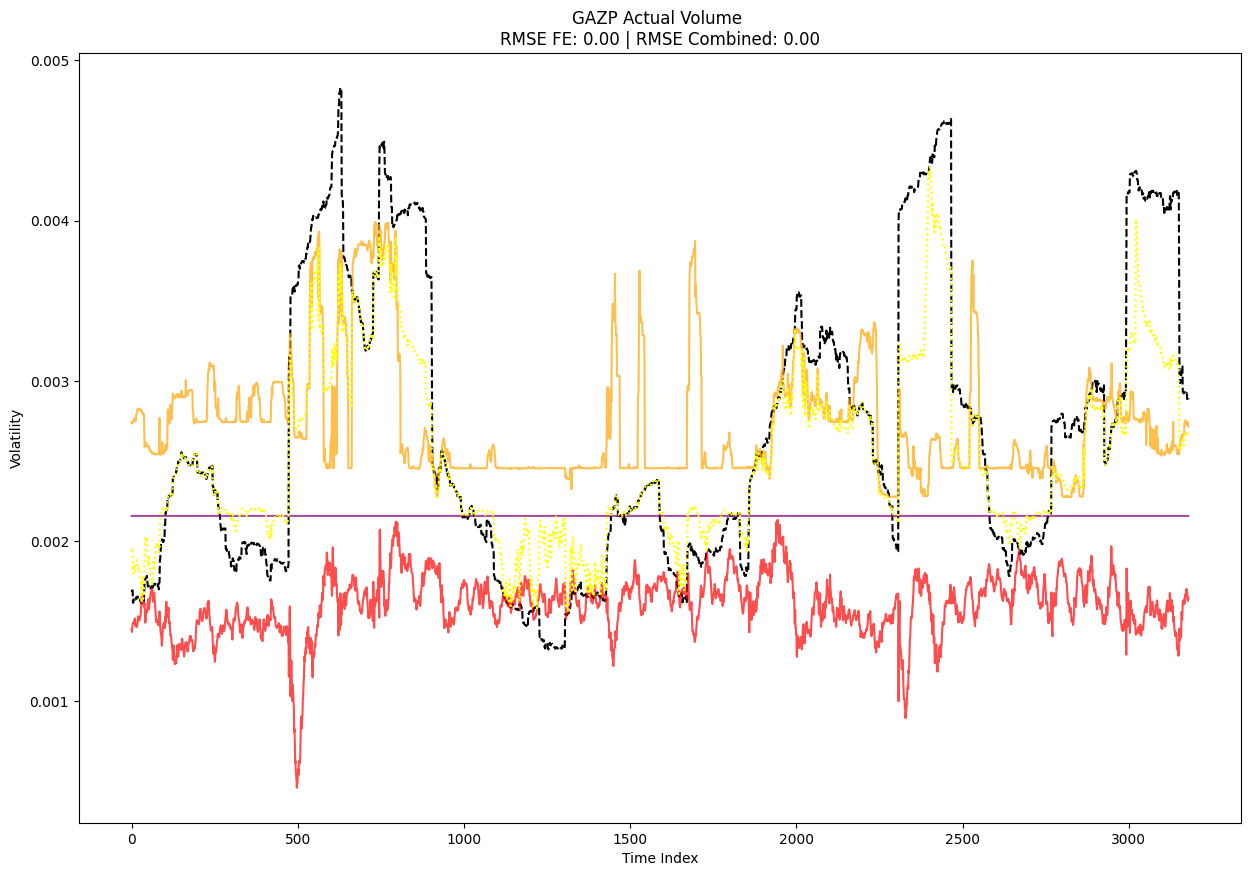

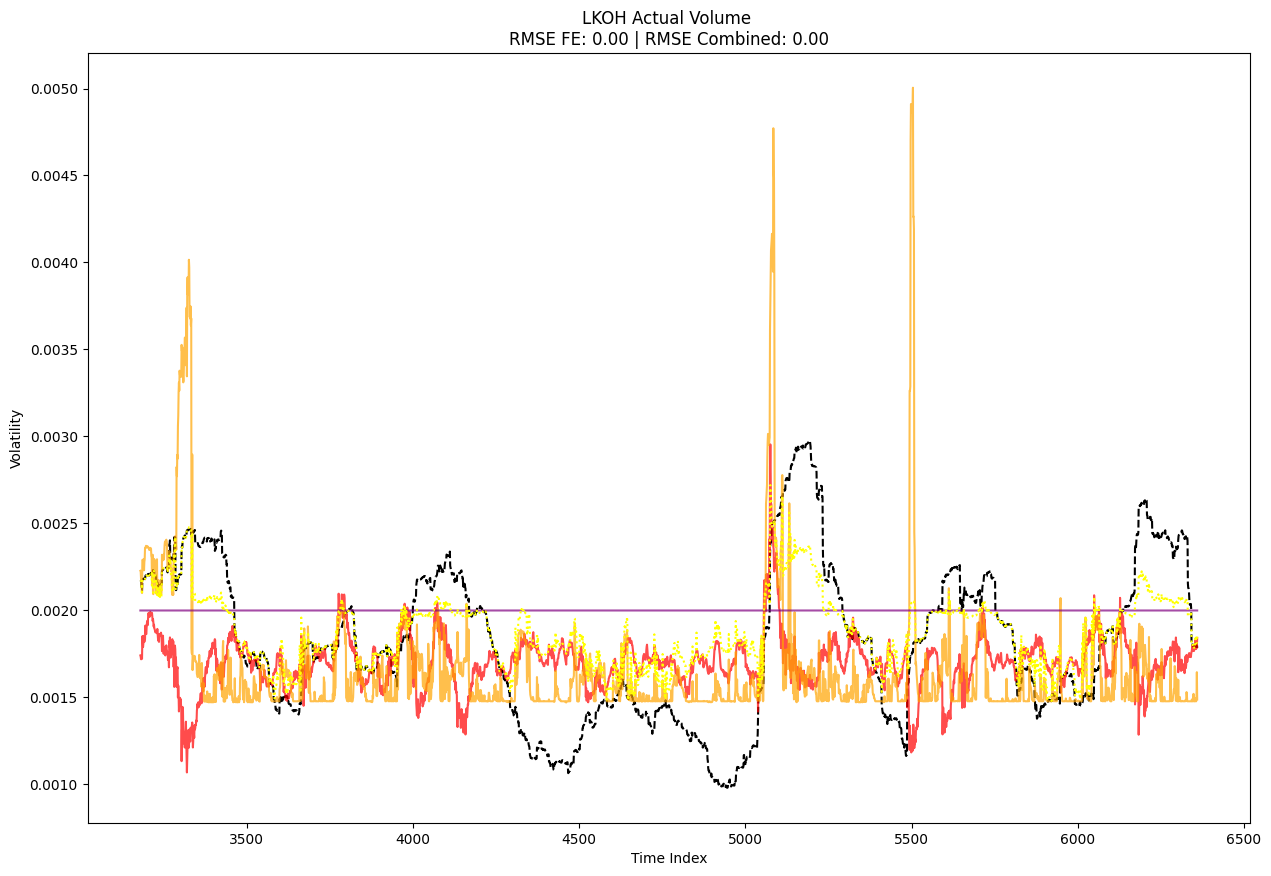

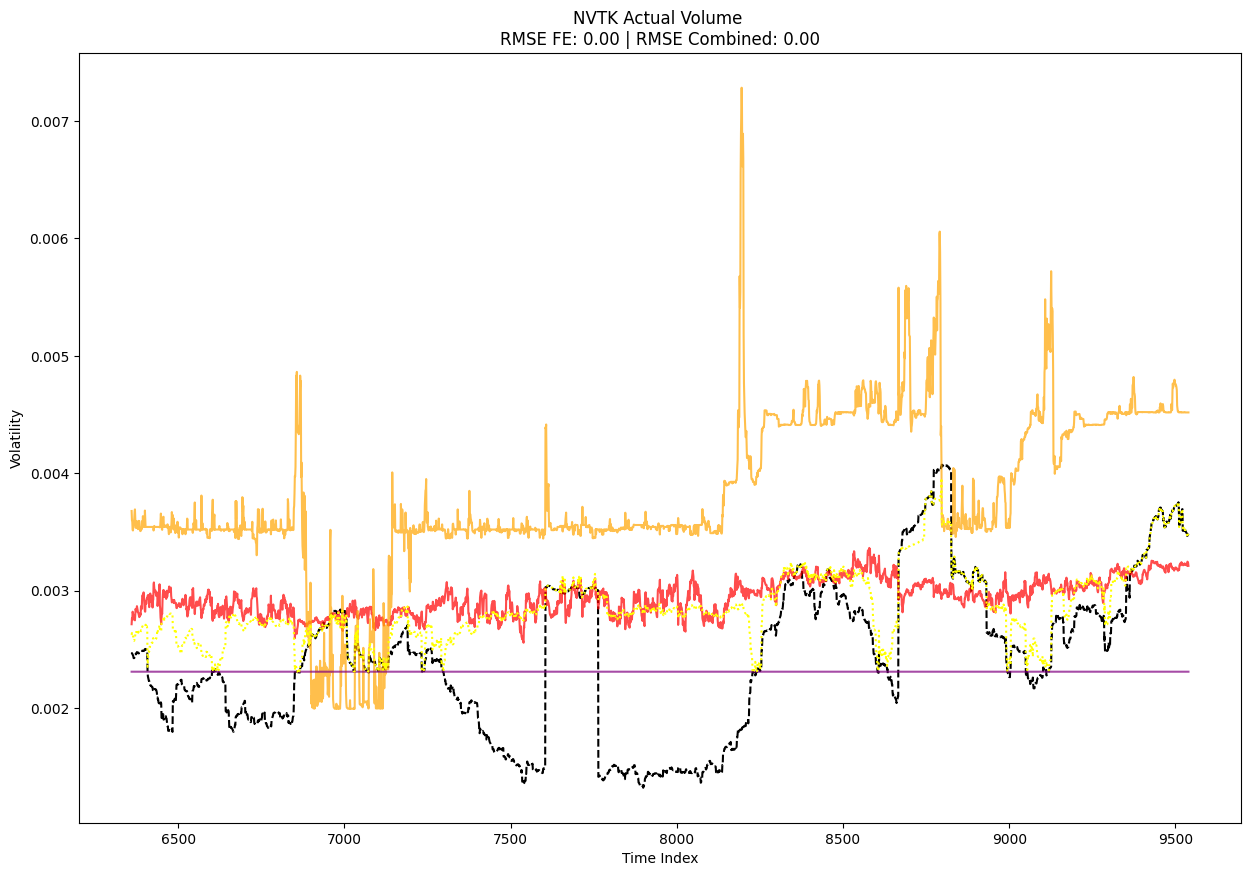

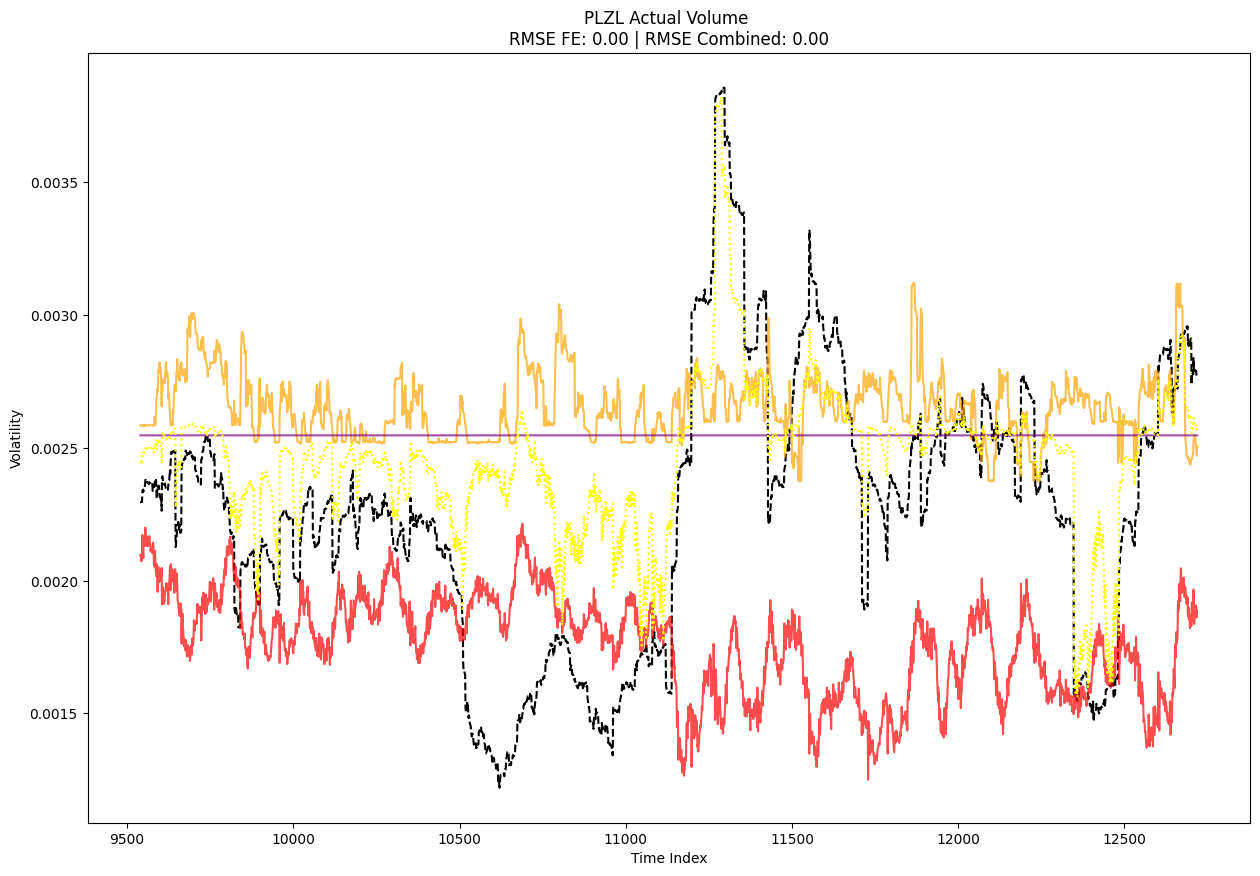

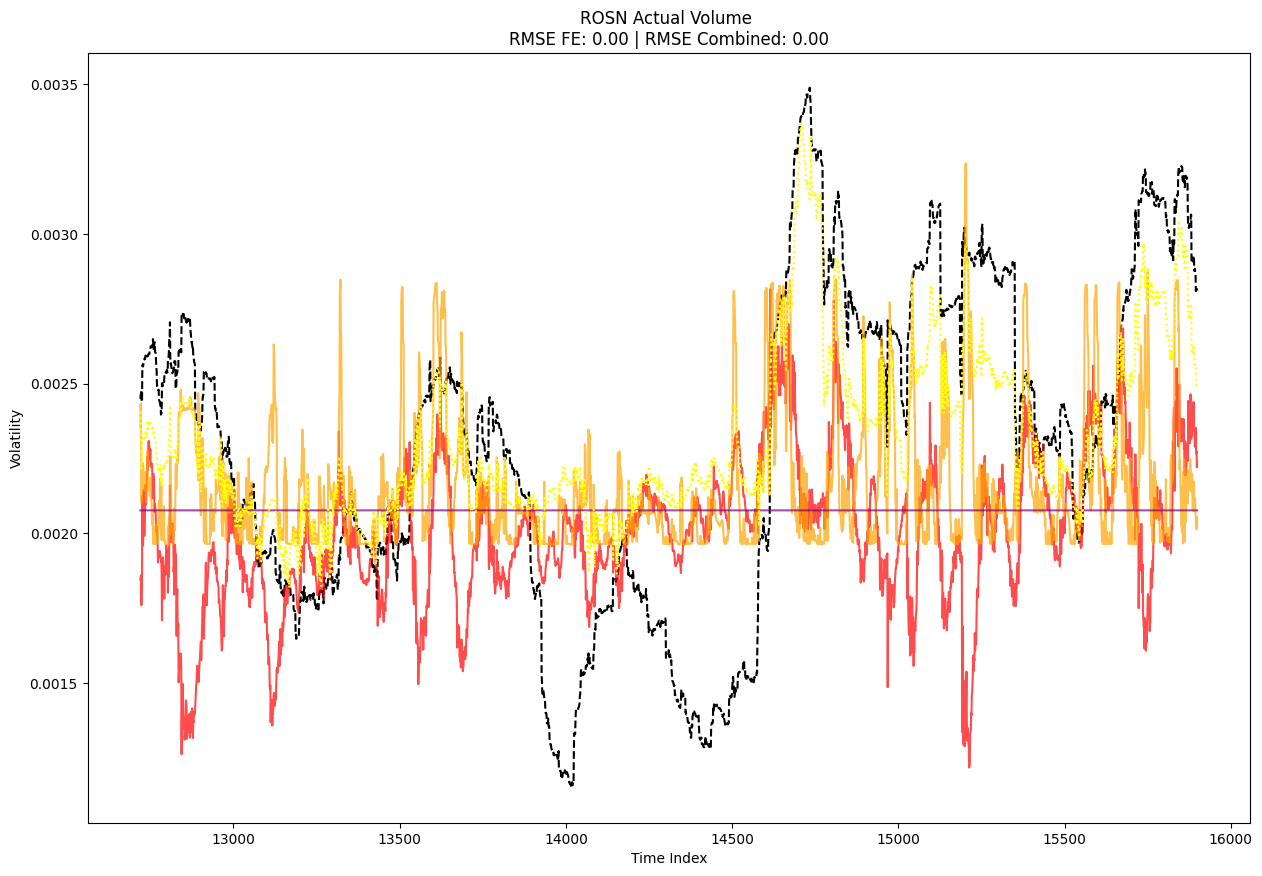

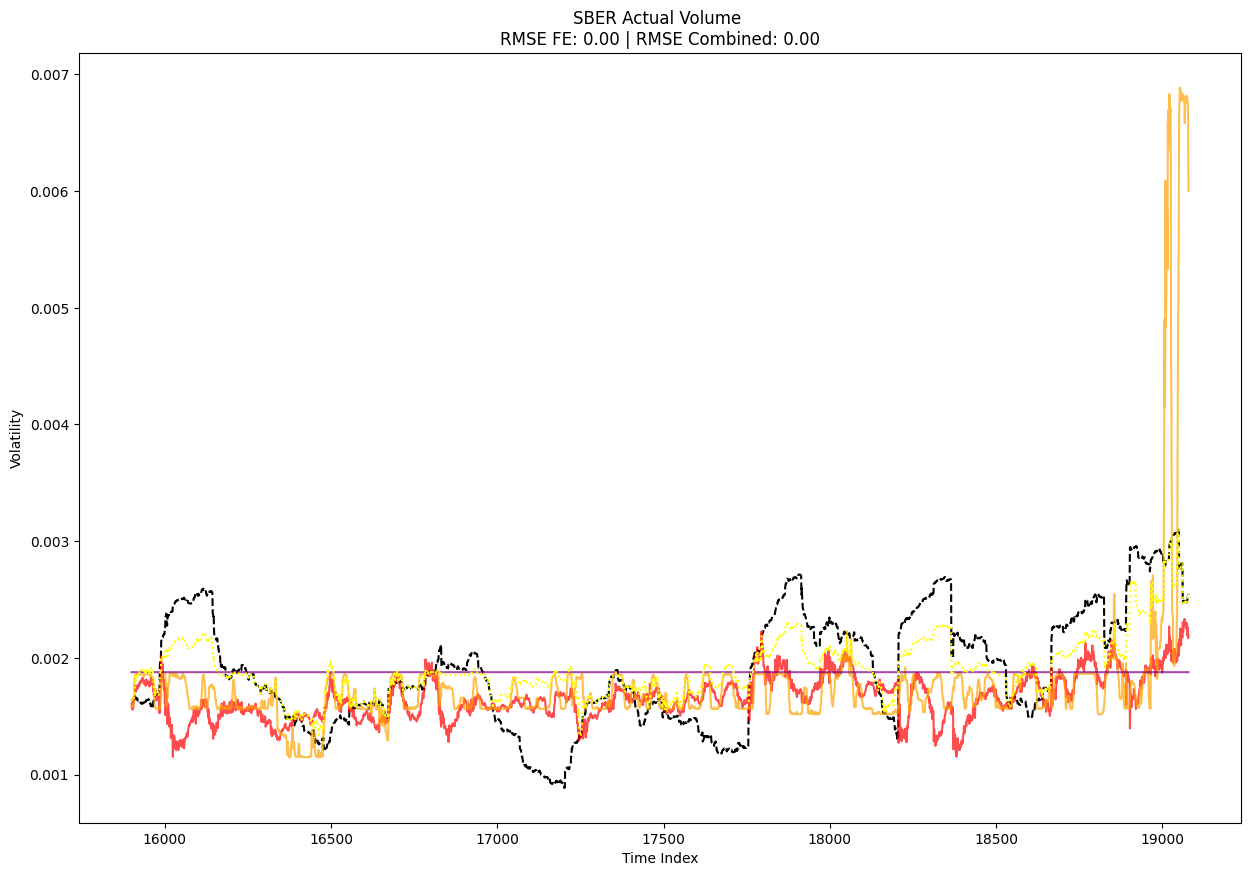

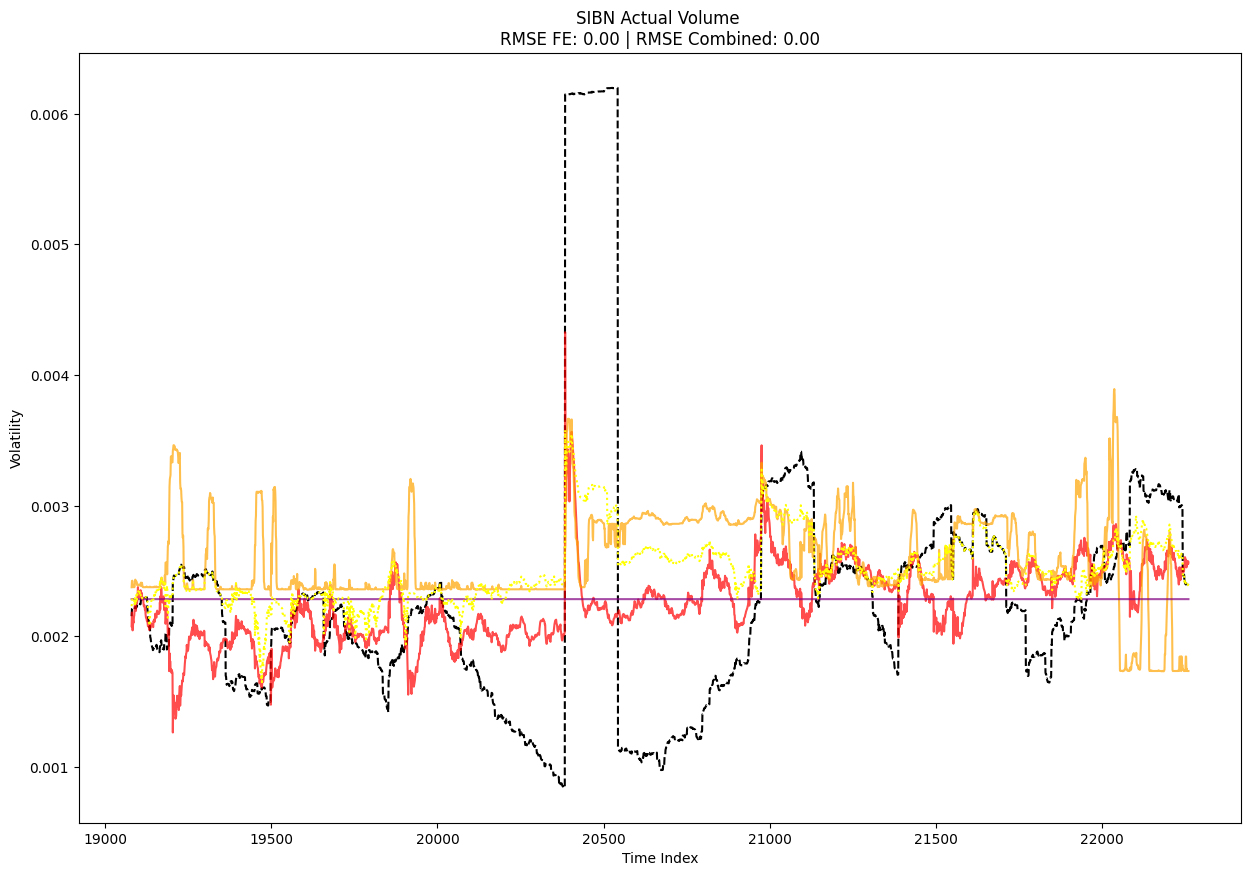

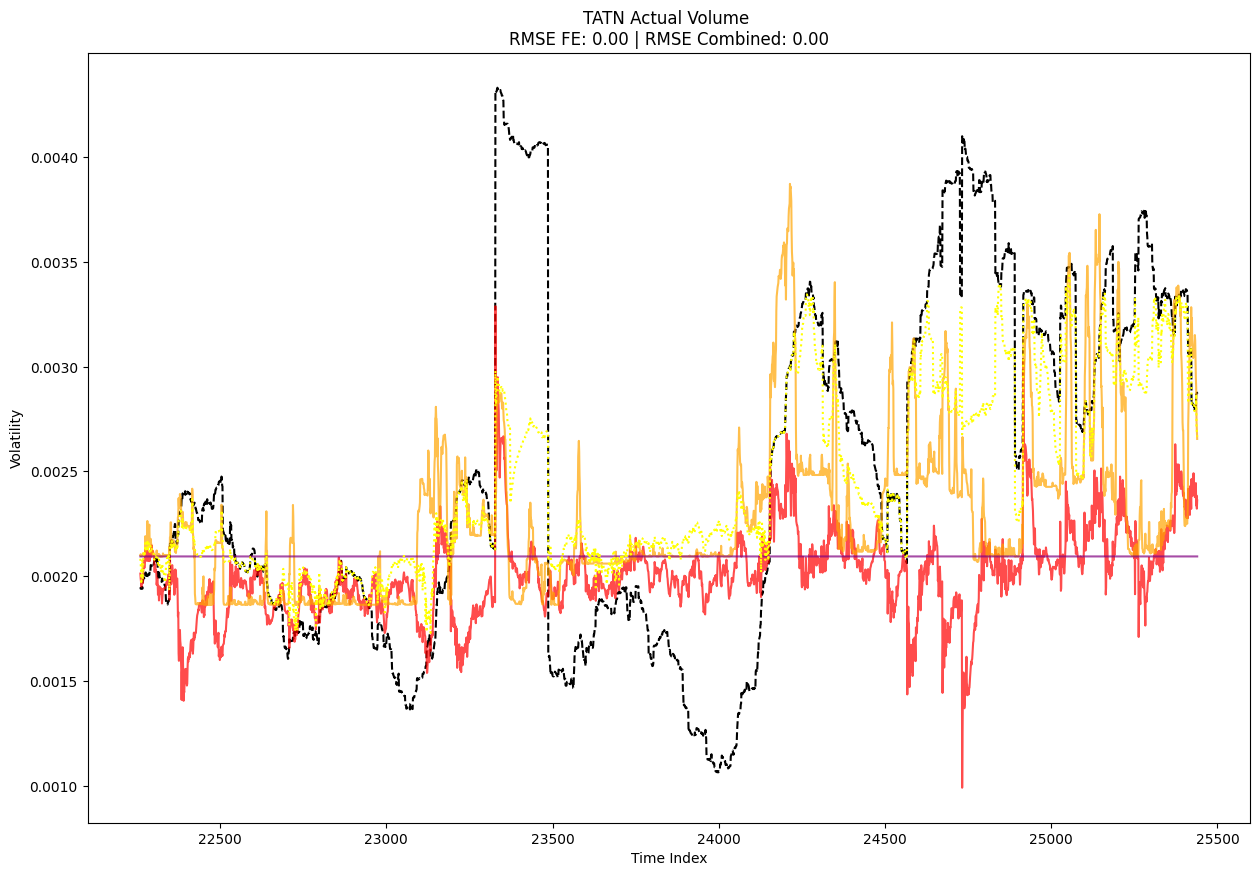

  ticker          mase           mse      rmse       mae       mape   rmse_lr  \
0   GAZP  9.312110e-10  1.962371e-07  0.000443  0.000299  10.441132  0.001424   
1   LKOH  2.806793e-08  9.889772e-08  0.000314  0.000218  14.521597  0.000489   
2   NVTK  3.092683e-08  4.425316e-07  0.000665  0.000453  25.977412  0.000786   
3   PLZL  1.515390e-07  1.504416e-07  0.000388  0.000283  15.626533  0.000784   
4   ROSN  7.326044e-09  1.275081e-07  0.000357  0.000276  14.674565  0.000629   
5   SBER  4.887587e-10  9.790595e-08  0.000313  0.000230  14.320020  0.000524   
6   SIBN  5.791523e-08  8.597991e-07  0.000927  0.000579  31.843172  0.001004   
7   TATN  1.856196e-08  2.966704e-07  0.000545  0.000371  17.277951  0.000936   

    rmse_fe   rmse_rf   rmse_gb  rmse_combined  
0  0.003600  0.000855  0.001039       0.000443  
1  0.001608  0.000530  0.000485       0.000314  
2  0.001231  0.001570  0.000667       0.000665  
3  0.001614  0.000644  0.000588       0.000388  
4  0.001194  0.000544  0.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

results = []

# Группировка по тикеру
for ticker in tickers:
    # Convert to DataFrames
    # df = ticker_dfs[ticker]['lstm'].reset_index(drop=True) # Results from models you already have
    # df = ticker_dfs[ticker]['fe'].reset_index(drop=True) # Assuming this is your feature-engineered model results
    
    # # Add other model results to df1
    # df = ticker_dfs[ticker]['rf'].reset_index(drop=True)
    # df = ticker_dfs[ticker]['gb'].reset_index(drop=True)

    df = ticker_dfs[ticker]
    # Calculate errors for each model
    df['error_lr'] = np.abs(df['lr'] - df['actual_vol'])
    df['error_lstm'] = np.abs(df['lstm'] - df['actual_vol'])
    df['error_fe'] = np.abs(df['fe'] - df['actual_vol'])
    df['error_rf'] = np.abs(df['rf'] - df['actual_vol'])
    df['error_gb'] = np.abs(df['gb'] - df['actual_vol'])

    # Calculate weights
    df['weight_lr'] = 1 / df['error_lr']
    df['weight_lstm'] = 1 / df['error_lr']
    df['weight_fe'] = 1 / df['error_fe']
    df['weight_rf'] = 1 / df['error_rf']
    df['weight_gb'] = 1 / df['error_gb']

    # df['weight_lstm'] = 1 / 4
    # df['weight_fe'] = 1 / 4
    # df['weight_rf'] = 1 / 4
    # df['weight_gb'] = 1 / 4

    # Normalize weights
    total_weights = (df['weight_lr'] + df['weight_fe'] +
                     df['weight_rf'] + df['weight_gb'] + df['weight_lstm'])

    df['norm_weight_lr'] = df['weight_lr'] / total_weights
    df['norm_weight_lstm'] = df['weight_lstm'] / total_weights
    df['norm_weight_fe'] = df['weight_fe'] / total_weights
    df['norm_weight_rf'] = df['weight_rf'] / total_weights
    df['norm_weight_gb'] = df['weight_gb'] / total_weights

    # Combined forecast
    combined_forecast = (df['norm_weight_lr'] * df['lr'] +
                         df['norm_weight_fe'] * df['fe'] +
                         df['norm_weight_rf'] * df['rf'] +
                         df['norm_weight_gb'] * df['gb'] + 
                         df['norm_weight_lstm'] * df['lstm'])

    rmse_lr = np.sqrt(mean_squared_error(df['actual_vol'], df['lr']))
    rmse_lstm = np.sqrt(mean_squared_error(df['actual_vol'], df['lstm']))
    rmse_fe = np.sqrt(mean_squared_error(df['actual_vol'], df['fe']))
    rmse_rf = np.sqrt(mean_squared_error(df['actual_vol'], df['rf']))
    rmse_gb = np.sqrt(mean_squared_error(df['actual_vol'], df['gb']))
    rmse_combined = np.sqrt(mean_squared_error(df['actual_vol'], combined_forecast))

    # Calculate additional metrics
    mse = mean_squared_error(df['actual_vol'], combined_forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(df['actual_vol'], combined_forecast)
    mape = np.mean(np.abs((df['actual_vol'] - combined_forecast) /df['actual_vol'])) * 100  # In percentage

    dd = load_data_1h(ticker)
    mase = calc_mase(df['actual_vol'], combined_forecast, dd['vol'][:-3180])
    

    # Save results
    results.append({
        'ticker': ticker,
        'mase': mase,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'rmse_lr': rmse_lr,
        'rmse_lstm': rmse_lr,
        'rmse_fe': rmse_fe,
        'rmse_rf': rmse_rf,
        'rmse_gb': rmse_gb,
        'rmse_combined': rmse_combined
    })

    # Plotting results
    plt.figure(figsize=(15, 10))
    plt.plot(df['actual_vol'], label='Actual Volatility', color='black', linestyle='--')
    plt.plot(df['lr'], label='LR Forecast', color='red', alpha=0.7)
    # plt.plot(df['lstm'], label='LSTM Forecast', color='red', alpha=0.7)
    # plt.plot(df['fe'], label='FE Forecast', color='blue', alpha=0.7)
    plt.plot(df['rf'], label='RF Forecast', color='orange', alpha=0.7)
    plt.plot(df['gb'], label='GB Forecast', color='purple', alpha=0.7)
    plt.plot(combined_forecast, label='Combined Forecast', color='yellow', linestyle=':')
    # plt.title(f'{ticker} Forecasts and Combined Forecast\nRMSE LSTM: {rmse_lstm:.2f} | RMSE FE: {rmse_fe:.2f} | RMSE RF: {rmse_rf:.2f} | RMSE GB: {rmse_gb:.2f} | RMSE Combined: {rmse_combined:.2f}')
    plt.title(f'{ticker} Actual Volume \nRMSE FE: {rmse_fe:.2f} | RMSE Combined: {rmse_combined:.2f}')
    plt.xlabel('Time Index')
    plt.ylabel('Volatility')
    # plt.legend()
    plt.show()

# Display RMSE results for all tickers
metrics_df = pd.DataFrame(results)
print(metrics_df)